In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.linalg import block_diag
from numpy.linalg import eigh

from scipy.constants import hbar, physical_constants

In [100]:
%matplotlib inline

We work in reduced units, defining the recoil wavevector as $k_\text{rec} = 2 \pi / \lambda$, where $\lambda$ is the studied transition’s wavelength: 
 - $\tilde{x} = k_\text{rec} x$
 - $\tilde{E} = \frac{E}{E_\text{rec}}$ where $E_\text{rec} = \frac{\hbar^2 k_\text{rec}^2}{2  m}$
 - $\tilde{\omega} = \frac{\hbar \omega}{E_\text{rec}}$.
 
We compute these factors here if we want to come back to SI units in the future.

In [3]:
lambda0 = 626.082e-9 #m
m_Dy = 162.5 * physical_constants["atomic mass constant"][0]
k_rec = 2*np.pi/lambda0
E_rec = hbar**2 * k_rec**2 / (2 * m_Dy)

# Definition of the problem

We consider a $\Lambda$ configuration with two ground states $|g_1\rangle$ and $|g_2\rangle$ and an excited state $|e\rangle$. Two laser beams couple the ground states to the excited state with Rabi frequencies $\Omega_c$ and $\Omega_p$, where $\Omega_c(x)$ depends on the position.

$\hat{H} = \frac{\hat{p}}{2 m} + (\omega_{g_1} - \omega_{g_2}) |g_2\rangle \langle g_2| + \omega_{g_1} |e\rangle \langle e| \\ + \Omega_c(x) \cos((\omega_{g_1} - \delta_{g_1}) t) (|g_1\rangle \langle e| + |e\rangle \langle g_1|) \\ + \Omega_p \cos((\omega_{g_2} - \delta_{g_2}) t) (|g_2\rangle \langle e| + |e\rangle \langle g_2|)$

# Born Oppenheimer Hamiltonian: existence of a dark state

In a first part, we study the Hamiltonian in the rotating wave approximation (RWA). The resulting time-independent Hamiltonian reads:

$\hat{H} = \frac{\hat{p}}{2 m} + \delta/2 (|g_2\rangle \langle g_2| - |g_1\rangle \langle g_1|) + \Delta |e\rangle \langle e| \\
+ \Omega_c(x)/2 (|g_1\rangle \langle e| + |e\rangle \langle g_1|) \\
+ \Omega_p/2 (|g_2\rangle \langle e| + |e\rangle \langle g_2|)$

We set $\hat{p} = 0$, placing ourselves in the Born-Oppenheimer approximation: we will see that this approximation is false, which will give rise to the sub-wavelength barrier.

We write the Hamiltonian in the base $|g_1\rangle$, $|g_2\rangle$, $|e\rangle$. For now we suppose the Raman resonance condition $\delta = 0$, and set a detuning $\Delta \neq 0$.

In [4]:
def H_RWA(delta, Delta, wc, wp):
    return np.array([[-delta/2, 0, wc/2],
                     [0, delta/2, wp/2],
                     [wc/2, wp/2, Delta]])

#def w_mean(wp, wc):
#    return np.sqrt(wp**2 + wc**2)

#def D(wc, wp):
#    return (1/w_mean(wp, wc)) * np.transpose(np.array([wp, -wc, 0]))


#def B():
#    return (1/np.sqrt(2)) * (plus() + minus())


### Example of the optical lattice

The simplest position dependency for $\Omega_c$ is the case of an optical lattice, where $\Omega_c(x) = \Omega_{c0} \sin(k x)$.

In [5]:
def wc(x, k, wc0):
    return wc0 * np.sin(k*x)

def dx_wc(x, k, wc0):
    return wc0 * k * np.cos(k*x)

We compute the eigenstates of the Hamiltonian for different positions for $k = k_\text{rec}$ for different values of $\epsilon = \Omega_p / \Omega_{c0}$:

In [6]:
eps = 0.1
delta = 0
Delta = 0
k = 1
x_array = np.linspace(-4, 4, 1000)
wc_array = np.array([wc(x, k, 1) for x in x_array])
wp = eps

eigvals = np.empty((len(x_array), 3), dtype=float)
eigvects = np.empty((len(x_array), 3, 3), dtype=complex)
for i, x in enumerate(x_array):
    eigvals[i,...], eigvects[i,...] = np.linalg.eigh(H_RWA(0, Delta, wc_array[i], wp))

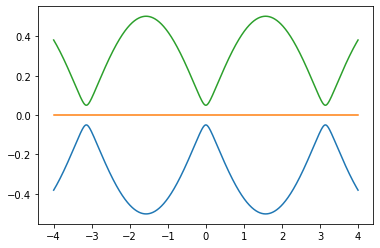

In [7]:
plt.plot(x_array, eigvals[:,0])
plt.plot(x_array, eigvals[:,1])
plt.plot(x_array, eigvals[:,2])

We can now show that the state of intermediate energy $| \Psi_2 \rangle$ is a dark state: it is decoupled from $|e\rangle$. The analytical expression of this dark state is $| \Psi_2 \rangle = \frac{1}{\overline{\Omega}} \Omega_p |g_1\rangle - \Omega_c |g_2\rangle$ and it has zero energy (for $\delta=0$ !) .

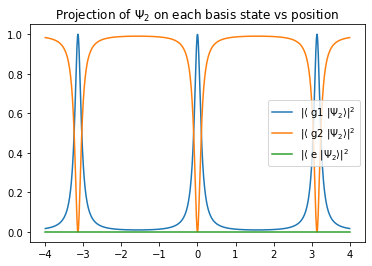

In [8]:
for i, state in enumerate(["g1", "g2", "e"]):
    plt.plot(x_array, np.square(np.abs(eigvects[:, i, 1])), label=rf"$ \| \langle$ {state} $| \Psi_2 \rangle \| ^2$")

plt.title(r"Projection of $\Psi_2$ on each basis state vs position")
plt.legend()

We can see that the dark state is mostly composed of $|g_2\rangle$ away from the zeros of $\Omega_c(x)$, and it "twists" to $|g_1\rangle$ on a layer of width proportional to $\epsilon$.

We denote the dark state $|D(x)\rangle$ and the lower and higher energy bright states respectively $|-(x)\rangle$ and $|+(x)\rangle$.

# Effective potential in the dark state basis, $\Delta = 0$

In the spirit of what Jendrzejewski does, we express the Hamiltonian in the basis $ \{ |\tilde{D}\rangle, |\tilde{-}\rangle, |\tilde{+}\rangle \}$ where $|\tilde{\psi}\rangle \ = | \psi (x_0) \rangle $ with $x_0$ a fixed position, applying to our hamiltonian the following unitary transformation:

$R^\dagger =  |\tilde{D}\rangle \langle D(x) | + |\tilde{-}\rangle \langle -(x) | + |\tilde{+}\rangle \langle +(x) |$

Let’s introduce the state $|B\rangle = 1/\sqrt{2} (|+\rangle + |-\rangle)$

The new Hamiltonian is then:

$H’ = \frac{(p - A)^2}{2m} + \hbar \bar{\Omega}(x) (| + \rangle \langle + | - | - \rangle \langle - |)$ where $A = i \hbar \frac{\Omega_p \partial_x \Omega_c(x)}{\bar{\Omega}(x)^2} (|\tilde{B}\rangle \langle \tilde{D} | - |\tilde{D}\rangle \langle \tilde{B} |)$

We place ourselve in the low $p$ limit, where $p^2$, $Ap$ and $pA$ can be neglected compared to $A^2$ :

In [9]:
#wp = 1
#wc = lambda x: x
#dx_wc = 1

In [10]:
D = np.array([[1, 0, 0]]).T
Plus = np.array([[0, 1, 0]]).T
Minus = np.array([[0, 0, 1]]).T

B = 1/np.sqrt(2) * (Plus + Minus)

A = lambda x: 1j * wp * dx_wc(x, k, 1) / (wp**2 + wc(x, k, 1)**2) * (B@D.T - D@B.T)

H = lambda x: A(x)@A(x) + (wp**2 + wc(x, k, 1)**2) * (Plus@Plus.T - Minus@Minus.T)


In [11]:
x_array = np.linspace(-4, 4, 1000)

eigvals = np.empty((len(x_array), 3), dtype=float)
eigvects = np.empty((len(x_array), 3, 3), dtype=complex)
for i, x in enumerate(x_array):
    eigvals[i,...], eigvects[i,...] = np.linalg.eigh(H(x))
    
U_eff = eigvals[:,1]

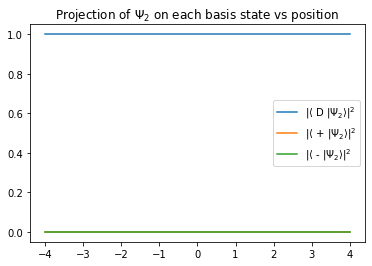

In [12]:
#plt.plot(x_array, np.square(np.abs(eigvects[:,0,1])))

for i, state in enumerate(["D", "+", "-"]):
    plt.plot(x_array, np.square(np.abs(eigvects[:, i, 1])), label=rf"$ \| \langle$ {state} $| \Psi_2 \rangle \| ^2$")

plt.title(r"Projection of $\Psi_2$ on each basis state vs position")
plt.legend()

Text(0, 0.5, '$E/E_R$')

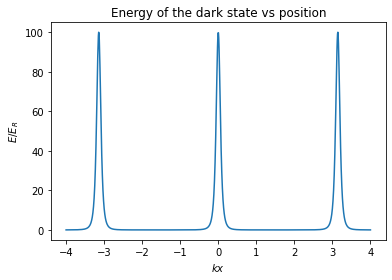

In [13]:
plt.plot(x_array, eigvals[:,1], label=rf"$| ${state}$ \rangle$")
plt.title("Energy of the dark state vs position")
plt.xlabel(r"$k x$")
plt.ylabel(r"$E/E_R$")

We can see that the dark state remains an eigenstate of the hamiltonian, and it experiences an effective potential barrier.

# Schrödinger equation solving for $p \neq 0$

We compute the eigenfunctions and eigenenergies without approximations for an atom trapped in a harmonic potential of frequency $\omega_t$ and, as previously, subjected to a uniform pump field and an optical lattice control field at Rabi frequencies $\Omega_p$ and $\Omega_c(x)$ satisfying the Raman resonance condition.

In [97]:
def solve_harm(wt, epsilon, wp, k_lattice=1, x_min=-4, x_max=4, N=500):

    V_analytical = lambda x: 1/4 * wt**2 * x**2
    wc0 = wp/eps

    delta_x = (x_min - x_max)/(N-1)
    x_array = np.linspace(x_min, x_max, N)
    
    dx = 1 / (2*delta_x) * (np.diag(np.ones((N-1,), dtype=float), k=1)
                              - np.diag(np.ones((N-1,), dtype=float), k=-1))
    dx[0, :3] = [-3, 4, -1]
    dx[-1, -3:] = [1, -4, 3]
    
    p_ext = -1j * dx

    p = block_diag(p_ext, p_ext, p_ext)

    K_ext = - 1 / (delta_x**2) * (np.diag(-2*np.ones((N,), dtype=float), k=0)
                                              + np.diag(np.ones((N-1,), dtype=float), k=1)
                                              + np.diag(np.ones((N-1,), dtype=float), k=-1))

    K = block_diag(K_ext, K_ext, K_ext)
    
    zeros =  np.zeros((N, N), dtype = complex)
    identity = np.eye(N, dtype = complex)

    g1_g1 = block_diag(identity, zeros, zeros)
    g2_g2 = block_diag(zeros, identity, zeros)
    e_e = block_diag(zeros, zeros, identity)
    
    wc_array = np.array([wc(x, k_lattice, wc0) for x in x_array])
    wc_diag = np.diag(wc_array)
    
    U_eff = wp**2 * (dx@wc_array)**2 / (wp**2 + wc_array**2)**2

    wc_over2_g1_e = np.block([[zeros, zeros, wc_diag],
                              [zeros, zeros, zeros],
                              [zeros, zeros, zeros]])

    wc_over2_e_g1 = wc_over2_g1_e.T

    g2_e = np.block([[zeros, identity, zeros],
                     [zeros, zeros, zeros],
                     [zeros, zeros, zeros]])

    e_g2 = g2_e.T

    U = delta/2 * (g2_g2 - g1_g1) + Delta * e_e + (wc_over2_g1_e + wc_over2_e_g1) + wp/2 * (g2_e + e_g2)

    V_ext = np.diag([V_analytical(x) for x in x_array])
    V = block_diag(V_ext, V_ext, V_ext)

    H = K + V + U
    
    sol = eigh(H)
    
    return {"eigvals": eigh(H)[0], "eigvects": eigh(H)[1], "x_array": x_array, "eps": epsilon, "wp": wp, "wt": wt, "U_eff": U_eff}

In [98]:
wt = hbar / E_rec * 2*np.pi*10e3 #Hz
eps = 0.1
wp = 3e3
V_analytical = lambda x: 1/4 * wt**2 * x**2
#U_eff = eps**2 * np.cos(x_array)**2 / (eps**2 + np.sin(x_array)**2)**2
#V_analytical = lambda x: 1/4 * wt**2 * x**2

In [99]:
sol = solve_harm(wt, eps, wp)

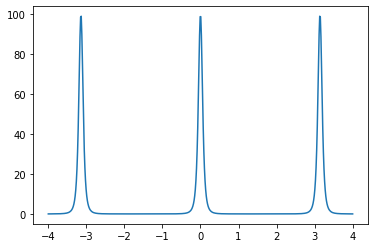

In [58]:
plt.plot(sol["x_array"], sol["U_eff"])

In [86]:
N = len(sol["x_array"])
zeros =  np.zeros((N, N), dtype = complex)
identity = np.eye(N, dtype = complex)
e_e = block_diag(zeros, zeros, identity)
i2 = np.argmin([np.sum(np.square(np.abs(e_e@sol["eigvects"][:,i]))) for i in range(N)])

In [87]:
i2

405

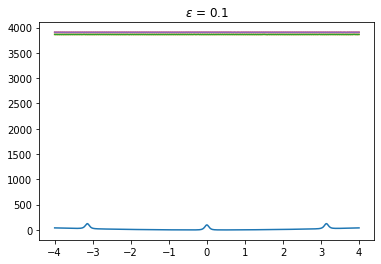

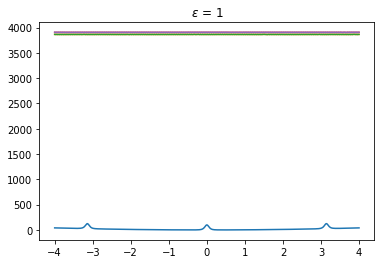

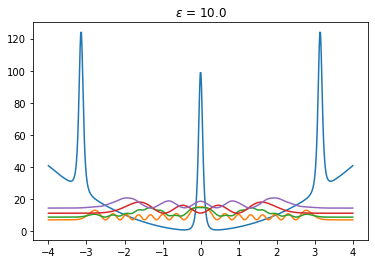

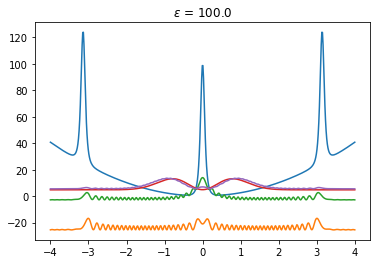

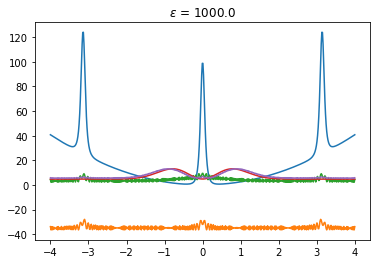

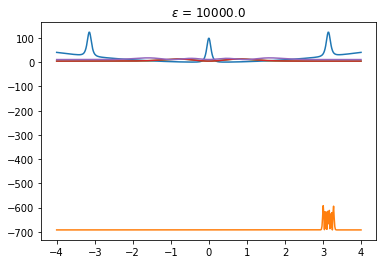

In [102]:
for wp in [1e-1, 1, 1e1, 1e2, 1e3, 1e4]:
    sol = solve_harm(wt, eps, wp)
    N = len(sol["x_array"])
    
    zeros =  np.zeros((N, N), dtype = complex)
    identity = np.eye(N, dtype = complex)
    e_e = block_diag(zeros, zeros, identity)
    i2 = np.argmin([np.sum(np.square(np.abs(e_e@sol["eigvects"][:,i]))) for i in range(N)])
    
    plt.figure()
    plt.plot(sol["x_array"], np.array([V_analytical(x) for x in sol["x_array"]]) + sol["U_eff"])
    
    for k in range(-2, 2):
        plt.plot(sol["x_array"], 1000*(np.square(np.abs(sol["eigvects"][:N,i2+k])) + np.square(np.abs(sol["eigvects"][N:2*N,i2+k])) + np.square(np.abs(sol["eigvects"][2*N:,i2+k])))  + sol["eigvals"][i2+k])
        plt.title(rf"$\Omega_p$ = {wp}")

In [22]:
e_e = block_diag(zeros, zeros, identity)
plt.plot([np.sum(np.square(np.abs(e_e@eigvects[:,i]))) for i in range(len(eigvects))])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 1500)

In [ ]:
i

In [ ]:
for eps in [1, 0.1, 0.01]:
    sol = solve_harm(wt, eps, wp, N=400)
    eigvals, eigvects = sol["eigvals"], sol["eigvects"]
    plt.plot(eigvals)
    plt.title(r"Spectrum dependency on $\epsilon$ at fixed $\Omega_p$")

plt.figure()
eps = 0.1
for wp in [1, 1e2, 1e3, 1e4]:
    sol = solve_harm(wt, eps, wp, N=400)
    eigvals, eigvects = sol["eigvals"], sol["eigvects"]
    plt.plot(eigvals)
    plt.title(r"Spectrum dependency on $\Omega_p$ at fixed $\epsilon$")

wp = 3e3